In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# collocation
import sys
import os
p_ = os.path.abspath(os.path.join('..', '00_utils'))
if p_ not in sys.path:
    sys.path.append(p_)
    
import collocation_obj
import importlib

In [53]:
from scipy.special import roots_legendre, legendre
n, _ = roots_legendre(100)

In [54]:
def legendre_poly_deriv(nodes):
    """
    Derivative of the n-th Legendre polynomial at x (Recurrence relations/ Bonnet's recursion formula)
    
    Rerefences:
    # https://math.stackexchange.com/questions/4751256/first-derivative-of-legendre-polynomial
    # https://en.wikipedia.org/wiki/Legendre_polynomials
    """
    n = len(nodes)
    Pn = legendre(n)(nodes)

    Pn_minus_1 = legendre(n-1)(nodes) if n > 1 else np.zeros_like(nodes)
    return n / (nodes**2 - 1) * (nodes * Pn - Pn_minus_1)

In [55]:
new_n = np.concatenate((np.array([0.0]), n))

In [39]:
import numpy as np

def legendre_poly_and_derivative(n):
    if n == 0:
        return np.poly1d([1]), np.poly1d([0])
    elif n == 1:
        return np.poly1d([1, 0]), np.poly1d([1])
    else:
        Pn_1 = np.poly1d([1, 0])
        dPn_1 = np.poly1d([1])
        Pn_2 = np.poly1d([1])
        dPn_2 = np.poly1d([0])
        for k in range(2, n + 1):
            Pn = ((2 * k - 1) * np.poly1d([1, 0]) * Pn_1 - (k - 1) * Pn_2) / k
            dPn = (k * Pn_1 + np.polyder(Pn_2 * k)) / k
            Pn_2, dPn_2 = Pn_1, dPn_1
            Pn_1, dPn_1 = Pn, dPn
        return Pn, dPn

def roots_legendre(n, tol=1e-14, max_iter=1000):
    Pn, dPn = legendre_poly_and_derivative(n)
    # Initial guesses using Chebyshev nodes
    x = np.cos(np.pi * (np.arange(n, 0, -1) - 0.25) / (n + 0.5))
    # Newton-Raphson refinement
    for i in range(max_iter):
        x_new = x - Pn(x) / dPn(x)
        if np.max(np.abs(x - x_new)) < tol:
            x = x_new
            break
        x = x_new
    x = np.sort(x)
    weights = 2 / ((1 - x**2) * (dPn(x)**2))
    return x, weights

# Example usage:
roots, weights = roots_legendre(50)
print("Roots:", roots)


Roots: [ -1.03113114  -1.00122287  -0.89716158  -0.86271106  -0.86254774
  -0.86216444  -0.85751375  -0.85472507  -0.85454964  -0.8544857
  -0.85447169  -0.85249507  -0.85197273  -0.85191361  -0.85128859
  -0.85113958  -0.85022961  -0.85000061  -0.84513099  -0.84164031
  -0.83235463  -0.78854224  -0.72479327   0.64190519   0.67831122
   0.72479327   0.78780974   0.81761126   0.84164031   0.84208061
   0.84784163   0.8482686    0.84846396   0.85113958   0.85129168
   0.85191361   0.85348544   0.85353272   0.85454964   0.8561969
   0.85634405   0.85705615   0.85751375   0.86271106   0.88994443
   0.9713442    1.00122287   1.03113114   1.0983414  108.56463133]


In [12]:
def f(x):
    return x * np.sin(x)

def df(x):
    return np.sin(x) + x*np.cos(x)

eval_pt = np.linspace(0, 2*np.pi, 100)
f_values = f(eval_pt)
df_analytical = df(eval_pt)
df_numerical = np.gradient(f_values, eval_pt)
error = np.linalg.norm(df_analytical - df_numerical)

print("Maximum error:", np.max(error))

Maximum error: 0.09501322546375748


## Regular Approach: Using all Nodes

In [14]:
importlib.reload(collocation_obj)
Collocation = collocation_obj.Collocation

gl_collocation = Collocation(32, 0, 6, 'gauss_legendre')

nodes = gl_collocation.compute_nodes()
D = gl_collocation.compute_derivative_matrix()

dy_dt = []

for i in range(len(nodes)):
    dy_dt.append(D[i] @ f(nodes))

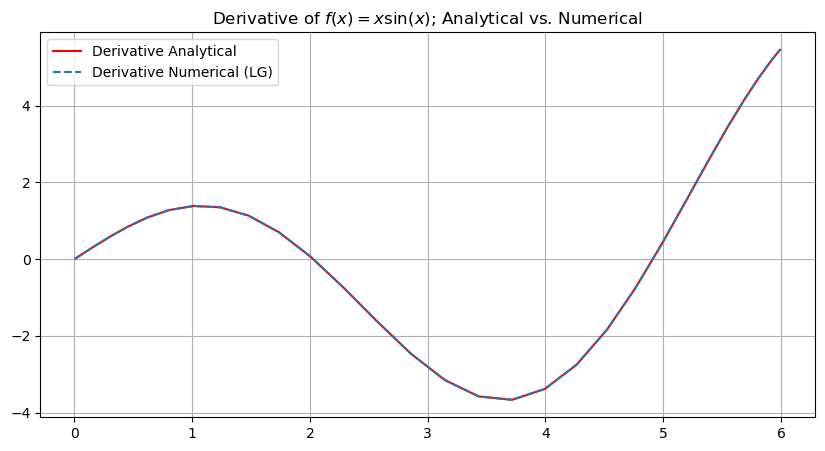

Maximum error: 0.09501322546375748


In [15]:
n = gl_collocation.compute_nodes()

plt.figure(figsize=(10, 5))
plt.plot(n, df(n), color='red', label=f'Derivative Analytical')
plt.plot(nodes, dy_dt, '--', label=f'Derivative Numerical (LG)')
plt.title('Derivative of $f(x) = x \sin(x)$; Analytical vs. Numerical')
plt.grid()
plt.legend()
plt.show();

# error = np.mean((df(nodes) - dy_dt)**2)

print("Maximum error:", np.max(error))

----

In [6]:
gl_collocation = Collocation(32, 0, 6, 'gauss_legendre')

nodes = gl_collocation.compute_nodes()
D = gl_collocation.compute_derivative_matrix()

dy_dt = []
nodes_filtered = []

for i in range(len(nodes)):
    if i % 2 == 0:
        nodes_filtered.append(nodes[i])
        dy_dt.append(D[i] @ f(nodes))

In [35]:
# this approach involves re-computing the nodes and derivative matrix
gl_collocation_16 = Collocation(16, 0, 6, 'gauss_legendre')

nodes_16 = gl_collocation_16.compute_nodes()
D_16 = gl_collocation_16.compute_derivative_matrix()

dy_dt_16 = []
nodes_filtered_16 = []
for i in range(len(nodes_16)):
    nodes_filtered_16.append(nodes_16[i])
    dy_dt_16.append(D_16[i] @ f(nodes_16))

In [36]:
n = gl_collocation.compute_nodes()

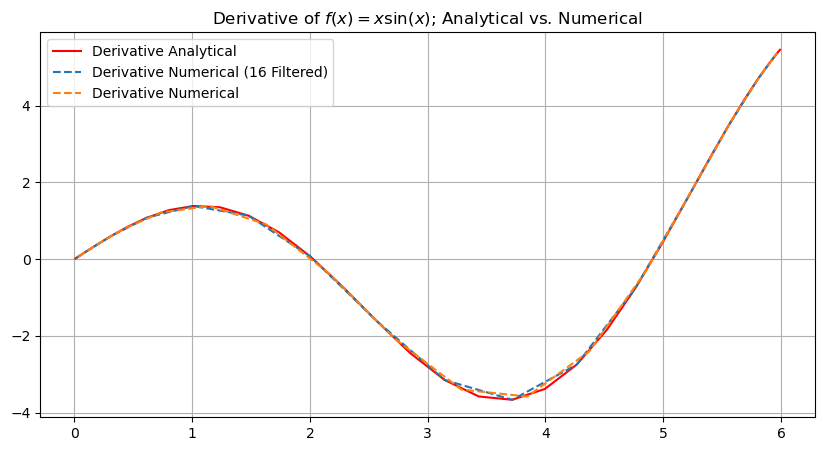

Maximum error: 0.09501322546375748


In [46]:
plt.figure(figsize=(10, 5))
plt.plot(n, df(n), color='red', label=f'Derivative Analytical')
plt.plot(nodes_filtered, dy_dt, '--', label=f'Derivative Numerical (16 Filtered)')
plt.plot(nodes_16, dy_dt_16, '--',label=f'Derivative Numerical')
plt.title('Derivative of $f(x) = x \sin(x)$; Analytical vs. Numerical')
plt.grid()
plt.legend()
plt.show();

# error = np.mean((df(nodes) - dy_dt)**2)

print("Maximum error:", np.max(error))